#**Table of Content**

* [1. Get the Data](#1.-Get-the-Data)
* [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
* [3.1 Preprocessing for Original Dataset](#3.1-Preprocessing-for-Original-Dataset)
* [3.2 Preprocessing for Aggregated Dataset](#3.2-Preprocessing-for-Aggregated-Dataset)
* [4. Modeling on Original Data](#4.-Modeling-on-Original-Data)
    * [4.1 Lasso Regression](#4.1-Lasso-Regression)
    * [4.2 Random Forest Regressor](#4.2-Random-Forest-Regressor)
    * [4.3 Multilayer Perceptron (MLP)](#4.3-Multilayer-Perceptron-(MLP))
* [5. Modeling on Aggregated Data (time-series models)](#5.-Modeling-on-Aggregated-Data-(time-series-models))
    * [5.1 SARIMAX with exogenous variables](#5.1-SARIMAX-with-exogenous-variables)
    * [5.2 Neural Prophet](#5.2-Neural-Prophet)
    * [5.3 Long short-term memory (LSTM) network](#5.3-Long-short-term-memory-(LSTM)-network)
* [6. Fine-tuning Models](#6.-Fine-tuning-Models)
* [7. Conclusion](#7.-Conclusion)
* [Appendix](#Appendix)
    * [a. Notebook Folder Link](#a.-Notebook-Folder-Link)
    * [b. Bibliography](#b.-Bibliography)

#**1. Get the Data**

This notebook focuses on predicting grocery store sales in Ecuador, utilising a dataset from a Kaggle competition. Four datasets were used in this project: the main sales dataset, the holiday events dataset, the oil price dataset, and the store information dataset. Given that the provided test dataset lacks target labels, I extracted a portion of the training dataset to serve as the test set for evaluating model performance. The datasets span from January 1, 2013, to August 15, 2017. The objective of this project is to forecast grocery sales from December 6, 2016, to August 15, 2017.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

df = pd.read_csv('train.csv', parse_dates=['date'])
holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])
oil = pd.read_csv('oil.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')

In [ ]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
# change 'date' into datetime
df['date'] = pd.to_datetime(df['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])

#**2. Exploratory Data Analysis**

In the exploratory data analysis (EDA) section, I explored various factors that could influence grocery store sales. The EDA involved several dimensions to uncover potential relationships, trends and seasonality within the dataset.

## Exploring relationship between Oil price and Grocery sales

In [ ]:
# First, I merged oil dataset with our main dataset
df = df.merge(oil, on = 'date', how = 'left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,NaN


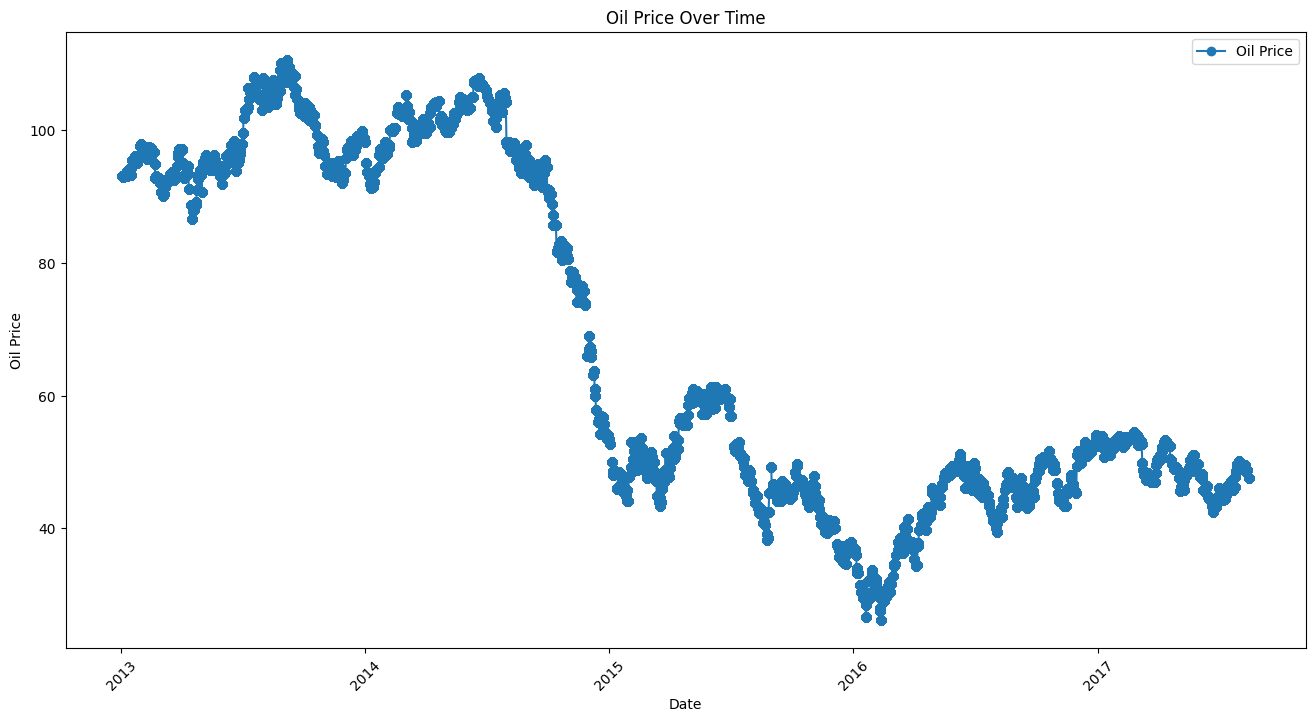

In [ ]:
# Visualise the oil prices to identify where the missing values are
df.sort_values('date', inplace=True)

plt.figure(figsize=(16, 8))
plt.plot(df['date'], df['dcoilwtico'], label='Oil Price', marker='o')
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.xticks(rotation=45)
plt.legend()

plt.show()

From the plot above, we can observe that missing values are scattered across various times, but can still clearly see the overall trend. Since oil prices may not change drastically in short periods, using the previous price is a reasonable assumption for the missing value. After this, there will be some missing values at the beginning of the dataset, I will use backward-fill to impute the remaining missing values.

In [ ]:
# Using forward-fill to impute the missing values
df['dcoilwtico'] = df['dcoilwtico'].fillna(method = 'ffill')

# Using backward-fill to impute the remaining missing values
df['dcoilwtico'] = df['dcoilwtico'].fillna(method = 'bfill')

# check if there are any remaining missing values.
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

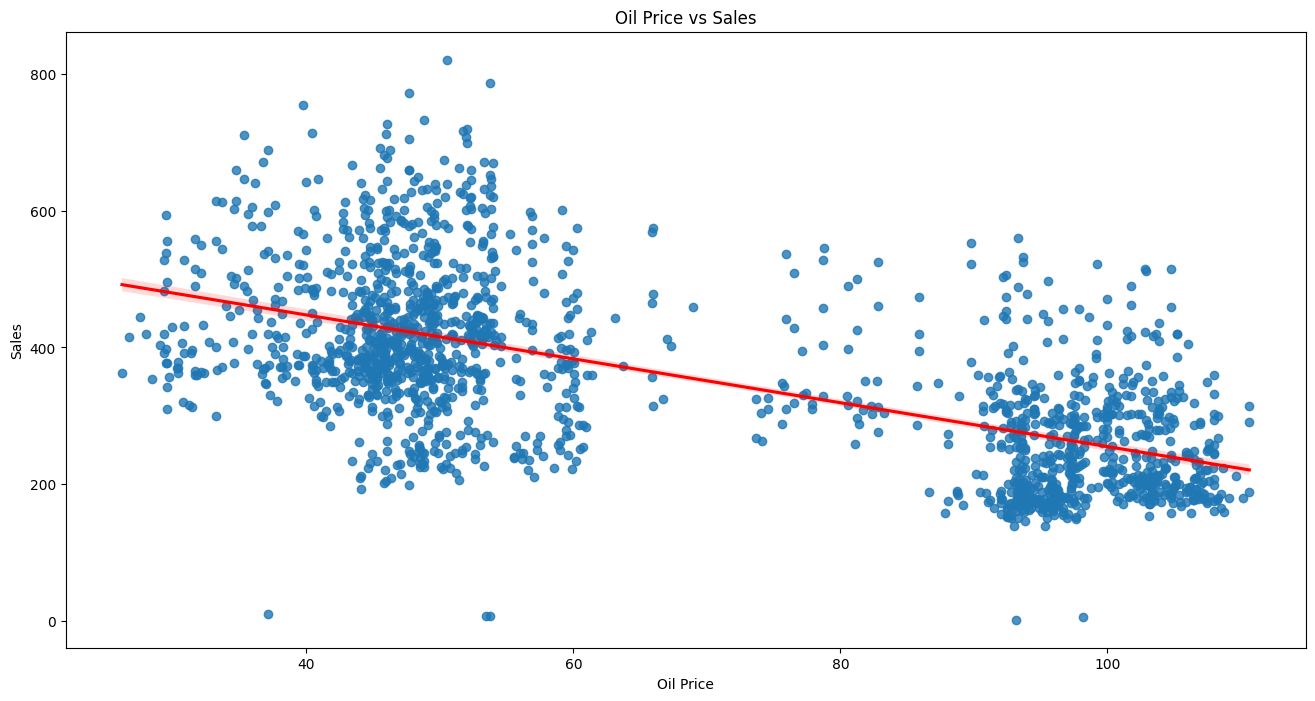

In [ ]:
# Then we check the correlation between Sales and Oil prices
daily_sales_avg = df.groupby('date')[['sales', 'dcoilwtico']].mean().reset_index()

plt.figure(figsize= (16, 8))
sns.regplot(data = daily_sales_avg, x = 'dcoilwtico', y = 'sales', line_kws = {'color': 'red'})

plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Oil Price vs Sales')

plt.show()

# From the correlation charts, we can observe that when oil prices increased, grocery sales decreased.

## Exploring relationship between Holidays and Grocery sales

In [ ]:
# Check how many types of holidays in 'locale' columns
holidays_events['locale'].value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [ ]:
# Then we check how each type of holiday affects grocery sales,
# we will first create 3 datasets for each type of holiday based on 'locale'.

holidays_national = holidays_events[holidays_events['locale'] == 'National']
holidays_local = holidays_events[holidays_events['locale'] == 'Local']
holidays_regional = holidays_events[holidays_events['locale'] == 'Regional']

In [ ]:
# Then we merge three datasets with our main dataset separately
sales_national = daily_sales_avg.merge(holidays_national, on = 'date', how = 'left')
sales_local = daily_sales_avg.merge(holidays_local, on = 'date', how = 'left')
sales_regional = daily_sales_avg.merge(holidays_regional, on = 'date', how = 'left')

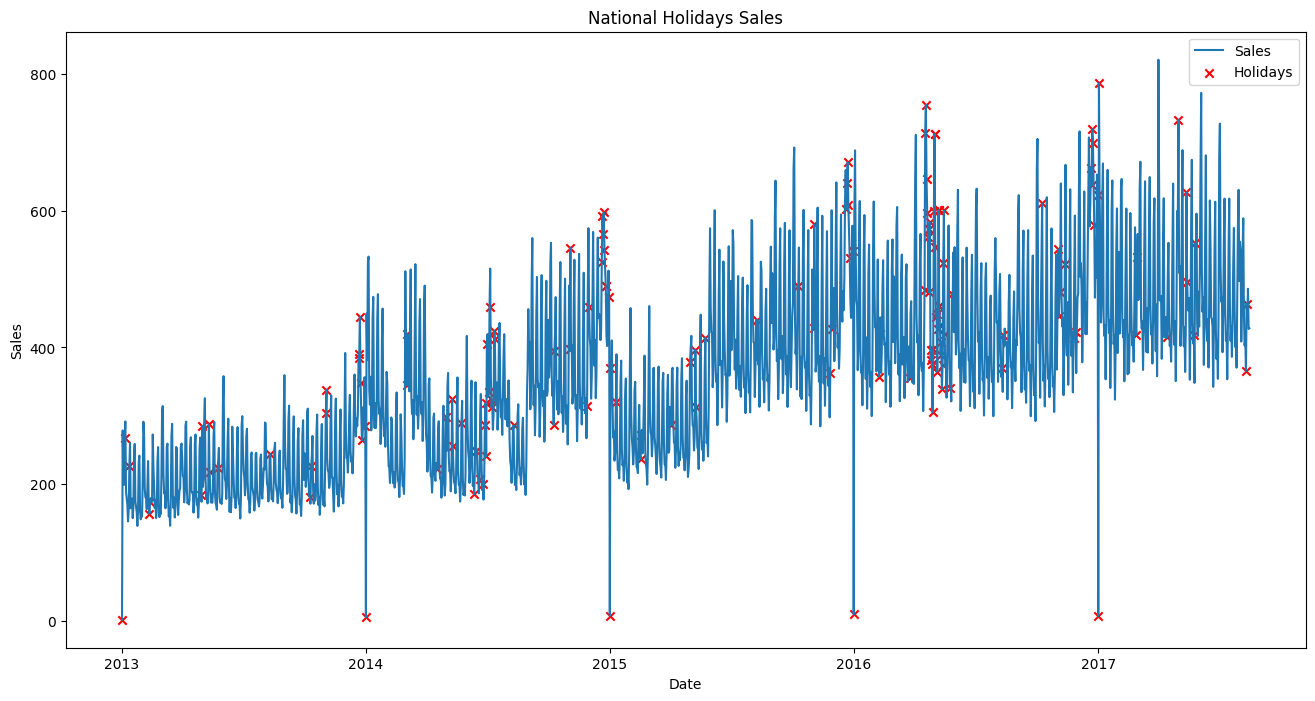

In [ ]:
# We observed that if the date does not correspond to a national holiday,
# the 'locale' column displays a NaN value. We can leverage this attribute in our visualization.

plt.figure(figsize = (16, 8))

plt.plot(sales_national['date'], sales_national['sales'], label = 'Sales')

# plot holidays as red markings on the chart
holidays_n = sales_national[sales_national['locale'].notna()]
plt.scatter(holidays_n['date'], holidays_n['sales'], marker = 'x', color = 'red', label = 'Holidays')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('National Holidays Sales')
plt.legend()

plt.show()

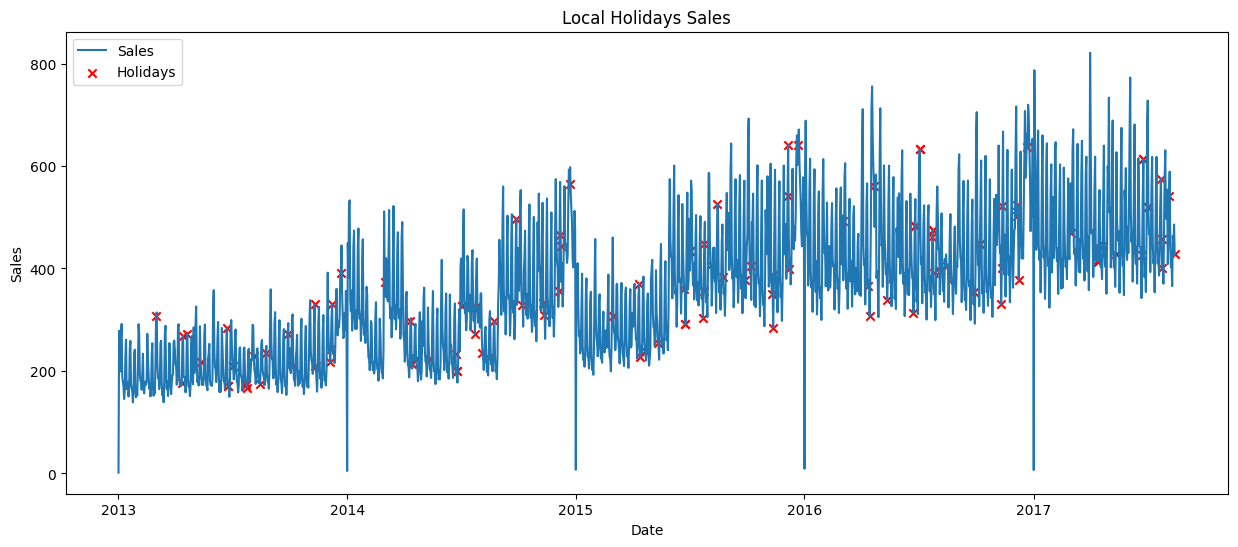

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(sales_local['date'], sales_local['sales'], label = 'Sales')

# plot holidays as red markings on the chart
holidays_l = sales_local[sales_local['locale'].notna()]
plt.scatter(holidays_l['date'], holidays_l['sales'], marker = 'x', color = 'red', label = 'Holidays')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Local Holidays Sales')
plt.legend()

plt.show()

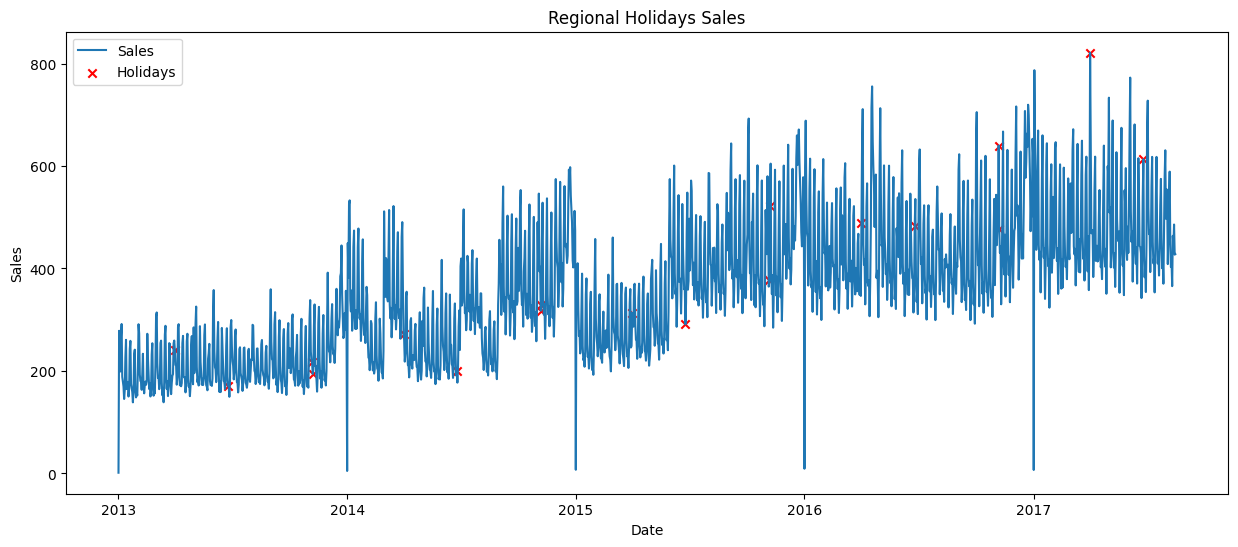

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(sales_regional['date'], sales_regional['sales'], label = 'Sales')

# plot holidays as red markings on the chart
holidays_r = sales_regional[sales_regional['locale'].notna()]
plt.scatter(holidays_r['date'], holidays_r['sales'], marker = 'x', color = 'red', label = 'Holidays')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Regional Holidays Sales')
plt.legend()

plt.show()

These three charts tell us that some peaks and low points in sales are related to holidays, which means holidays are important predictors. Therefore, I kept them in our features.

In [ ]:
# Note that some days feature two or three types of locales.
# Ignoring this will result in additional rows for the same date when merging datasets.
# Based on our visualisations, I prioritise the holiday types in this order: National > Local > Regional.
# For example, if there is a 'National' holiday on the same date as any other type, we keep only the 'National' holiday.

# We check whether there are multiple locales on the same data here
date_counts = holidays_events['date'].value_counts()
# Filter for dates with more than one entry
duplicate_date = date_counts[date_counts > 1]

if duplicate_date.sum() > 1:
  print('There are duplicate dates')
else:
  print('No duplicate date')

There are duplicate dates


In [ ]:
# Sort by 'date' and 'holiday_type' to ensure 'National' comes first, then 'Local', then 'Regional'
holidays_events['locale'] = pd.Categorical(holidays_events['locale'], ['National', 'Local', 'Regional'])
holidays_events = holidays_events.sort_values(by = ['date', 'locale'])

In [ ]:
# Drop duplicates, keeping the first entry of the date which is the highest priority holiday
holidays_events = holidays_events.drop_duplicates(subset = ['date'], keep = 'first')

holidays_events['locale'].value_counts()

locale
National    168
Local       126
Regional     18
Name: count, dtype: int64

In [ ]:
# Since we only need one hot 'locale' columns, I drop other columns here
holidays_events = holidays_events.drop(['type', 'locale_name', 'description', 'transferred'], axis =1)

In [ ]:
# Create a copy for df
df2 = df.copy()

In [ ]:
# After processing the holiday dataset, we can merge it with our main dataset.
df2 = df2.merge(holidays_events, on = 'date', how = 'left')

In [ ]:
df2

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,locale
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,National
1,1194,2013-01-01,42,CELEBRATION,0.000,0,93.14,National
2,1193,2013-01-01,42,BREAD/BAKERY,0.000,0,93.14,National
3,1192,2013-01-01,42,BOOKS,0.000,0,93.14,National
4,1191,2013-01-01,42,BEVERAGES,0.000,0,93.14,National
...,...,...,...,...,...,...,...,...
3000883,2999693,2017-08-15,25,PET SUPPLIES,3.000,0,47.57,Local
3000884,2999692,2017-08-15,25,PERSONAL CARE,93.000,8,47.57,Local
3000885,2999691,2017-08-15,25,MEATS,180.107,0,47.57,Local
3000886,2999702,2017-08-15,26,BEAUTY,0.000,0,47.57,Local


##Exploring relationships between stores and sales

In [ ]:
df2 = df2.merge(stores, on = 'store_nbr', how = 'left')

In [ ]:
# 'cluster' column put similar stores together.
# I would only use 'cluster' column, so I dropped other features here
df2 = df2.drop(['city', 'state', 'type'], axis =1)

In [ ]:
df2

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,locale,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,National,13
1,1194,2013-01-01,42,CELEBRATION,0.000,0,93.14,National,2
2,1193,2013-01-01,42,BREAD/BAKERY,0.000,0,93.14,National,2
3,1192,2013-01-01,42,BOOKS,0.000,0,93.14,National,2
4,1191,2013-01-01,42,BEVERAGES,0.000,0,93.14,National,2
...,...,...,...,...,...,...,...,...,...
3000883,2999693,2017-08-15,25,PET SUPPLIES,3.000,0,47.57,Local,1
3000884,2999692,2017-08-15,25,PERSONAL CARE,93.000,8,47.57,Local,1
3000885,2999691,2017-08-15,25,MEATS,180.107,0,47.57,Local,1
3000886,2999702,2017-08-15,26,BEAUTY,0.000,0,47.57,Local,10


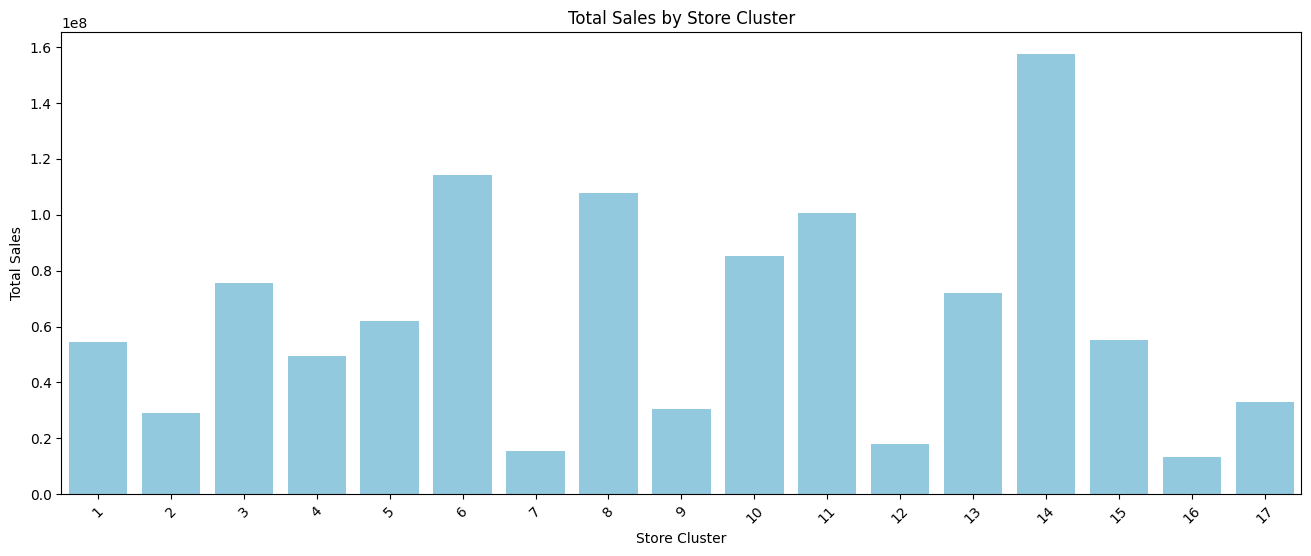

In [ ]:
# I was interested in which store cluster had the highest total sales and which store cluster had the lowest total sales.

# Creating a bar plot
store_cluster_sales = df2.groupby('cluster')['sales'].sum().reset_index()
store_cluster_sales = store_cluster_sales.sort_values('sales', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(data = store_cluster_sales, x = 'cluster', y = 'sales',color = 'skyblue')

plt.xlabel('Store Cluster')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Cluster')
plt.xticks(rotation=45)
plt.show()

##Exploring Product families

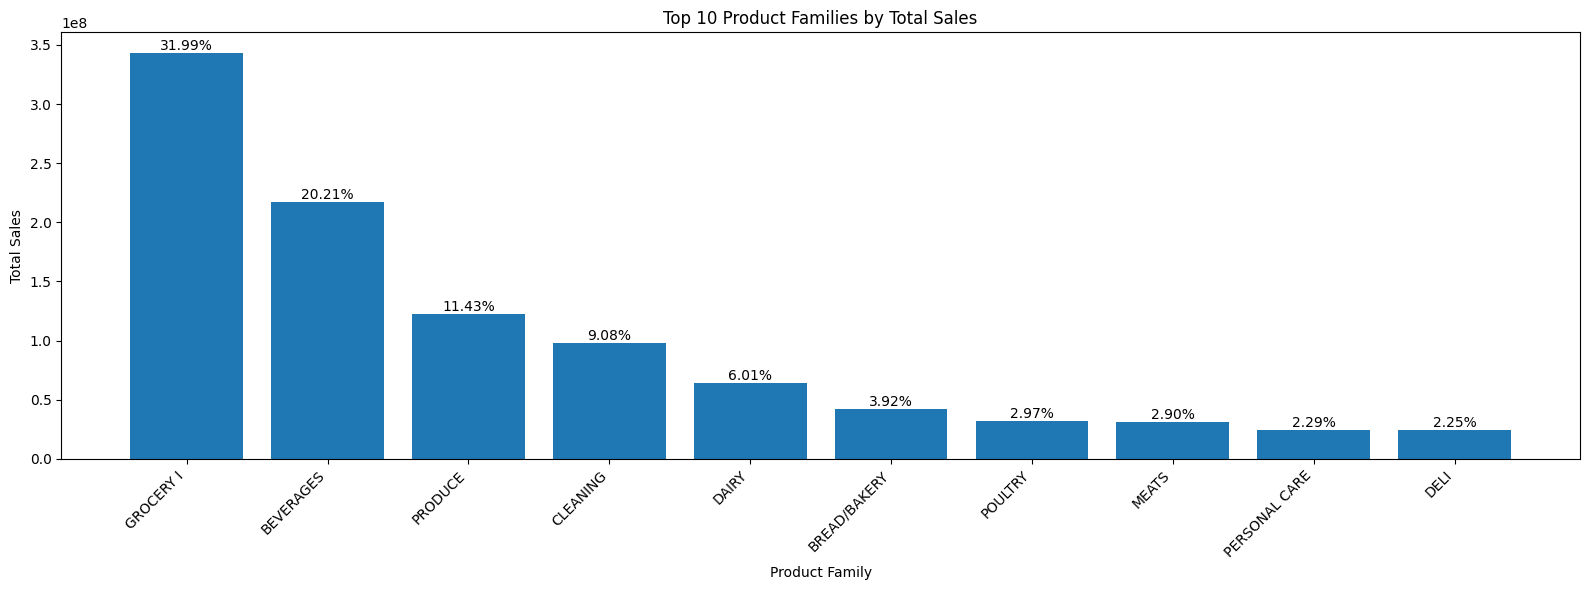

In [ ]:
total_sales_by_family = df2.groupby('family')['sales'].sum().reset_index()
top_10_families = total_sales_by_family.sort_values(by='sales', ascending = False).head(10)

# Calculate total sales across all families for percentage calculation
total_sales = total_sales_by_family['sales'].sum()

# Calculate the percentage of total sales for the top 10 families
top_10_families['percentage'] = (top_10_families['sales'] / total_sales) * 100

plt.figure(figsize=(16, 6))
bars = plt.bar(top_10_families['family'], top_10_families['sales'])
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.title('Top 10 Product Families by Total Sales')
plt.xticks(rotation=45, ha="right")

# display percentages of each product family
for bar, percentage in zip(bars, top_10_families['percentage']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout()

The bar chart shows that the top 5 product families almost account for 80% of total sales. Therefore, I grouped the remaining product families into a family called "other" in the data cleaning phase. By doing this, we could reduce the number of product families and reduce the dummy variables.

##Analysing Overall Trend

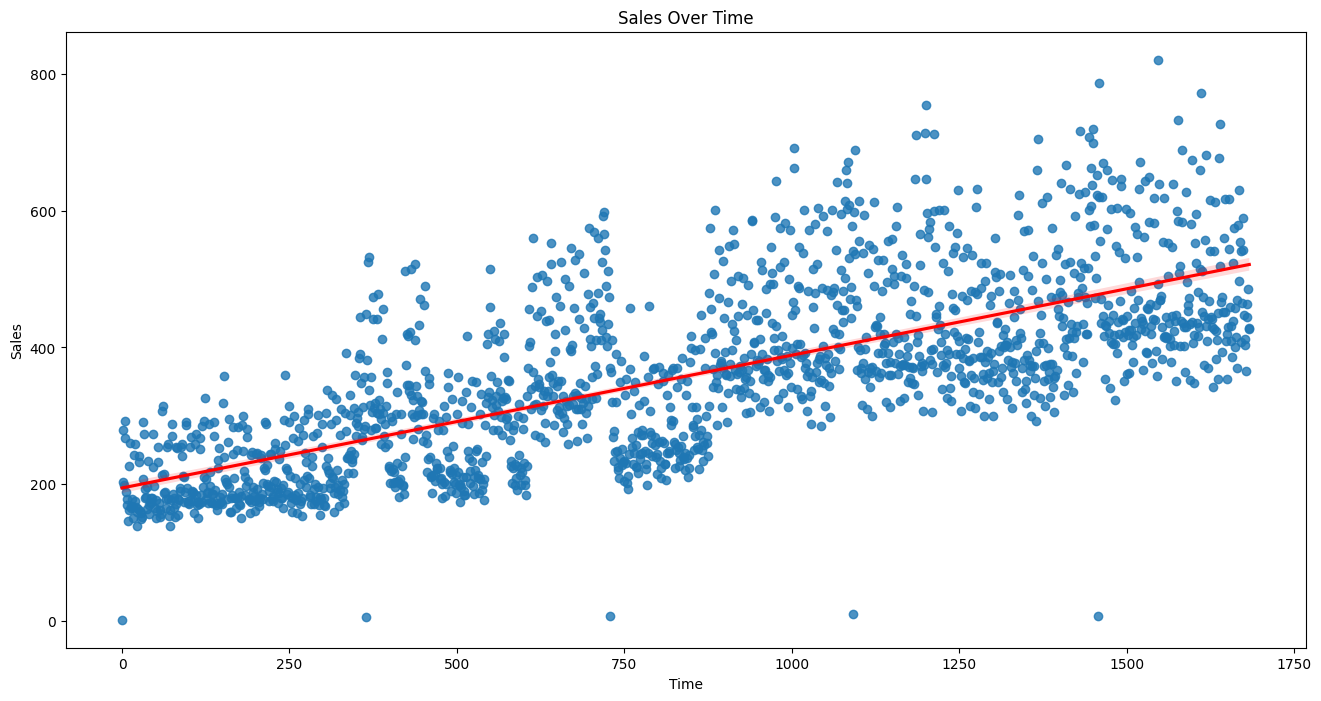

In [ ]:
plt.figure(figsize=(16, 8))
daily_sales_avg['time'] = np.arange(len(daily_sales_avg))
sns.regplot(data=daily_sales_avg, x='time', y='sales', line_kws={"color": "red"})

plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Over Time')

plt.show()

# We can observe that sales increased over time

##Analysing Seasonality

### Periodogram

In [ ]:
daily_sales_avg.set_index('date', inplace=True)

# Extract the day of week, month and year from the 'date' column
daily_sales_avg['year'] = daily_sales_avg.index.year
daily_sales_avg['year_day'] = daily_sales_avg.index.day_of_year
daily_sales_avg['month'] = daily_sales_avg.index.month
daily_sales_avg['month_day'] = daily_sales_avg.index.day
daily_sales_avg['weekday'] = daily_sales_avg.index.weekday

In [ ]:
from scipy.signal import periodogram

In [ ]:
frequencies, spectrum = periodogram(daily_sales_avg['sales'], scaling='density')

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    if ax is None:
        _, ax = plt.subplots(figsize=(16, 6))

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

<Figure size 1600x800 with 0 Axes>

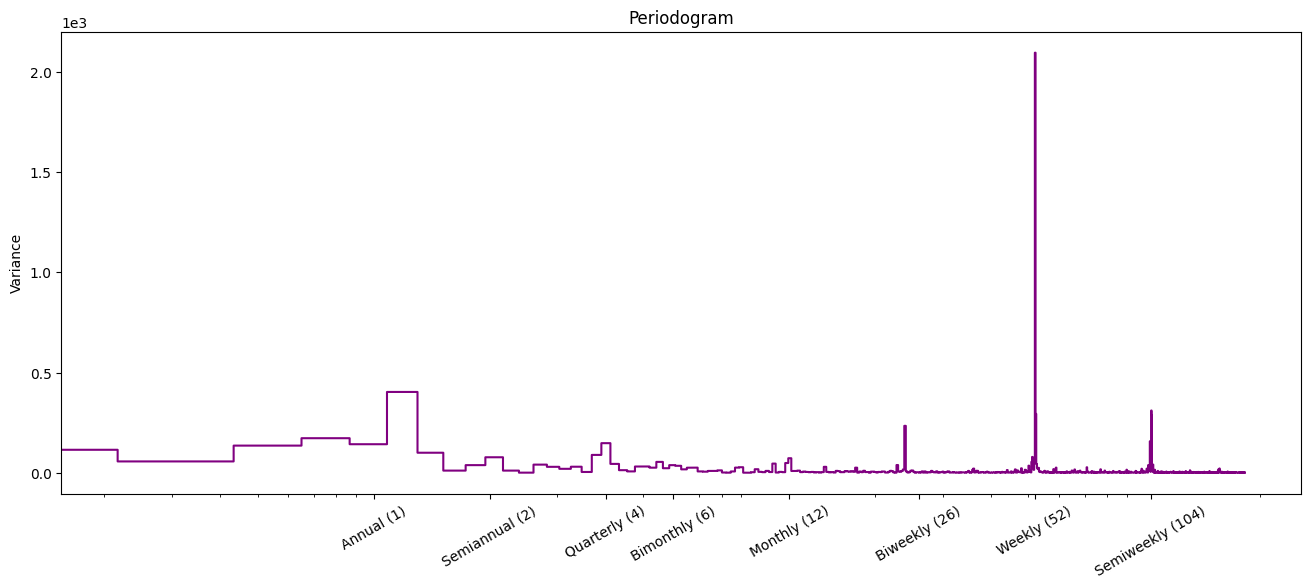

In [ ]:
plt.figure(figsize=(16, 8))
plot_periodogram(daily_sales_avg['sales'])
plt.show()

# According to the Periodogram, we have a very strong weekly seasonality.
# Biweekly and yearly seasonality could also be observed in our dataset.

###Average Sales per Month over time

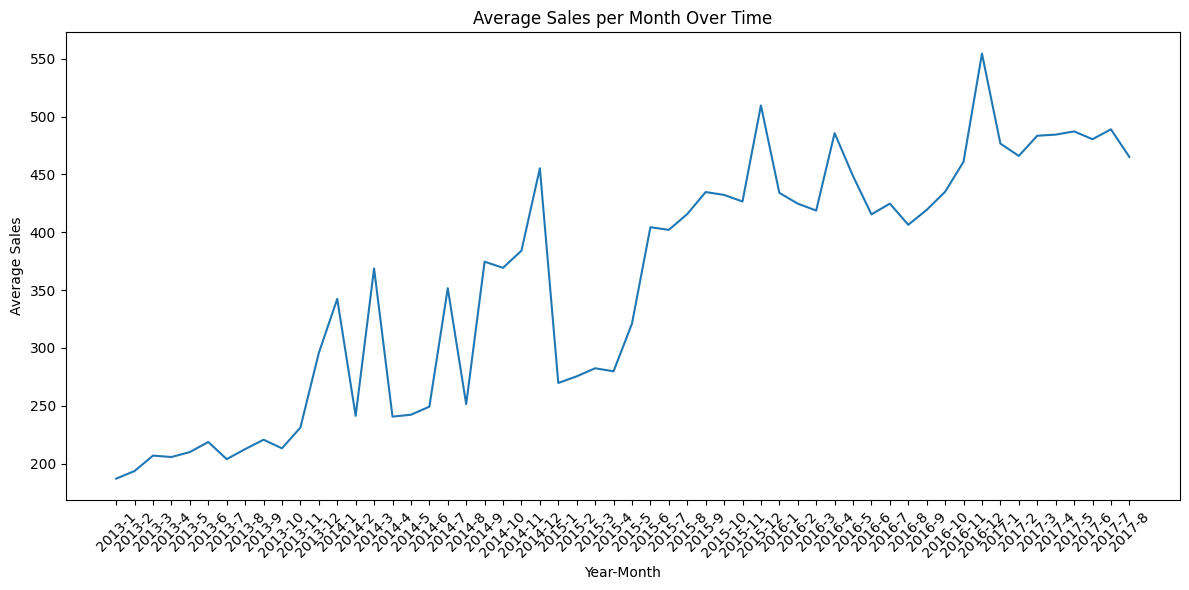

In [ ]:
yearly_monthly_sales_avg = daily_sales_avg.groupby(['year', 'month'])['sales'].mean().reset_index()

# To make the x-axis labels more readable, we will combine year and month into a single string
yearly_monthly_sales_avg['year_month'] = yearly_monthly_sales_avg['year'].astype(str) + '-' + yearly_monthly_sales_avg['month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data = yearly_monthly_sales_avg, x='year_month', y='sales')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Average Sales')
plt.title('Average Sales per Month Over Time')
plt.tight_layout()

plt.show()

###Average Daily Sales within a Year

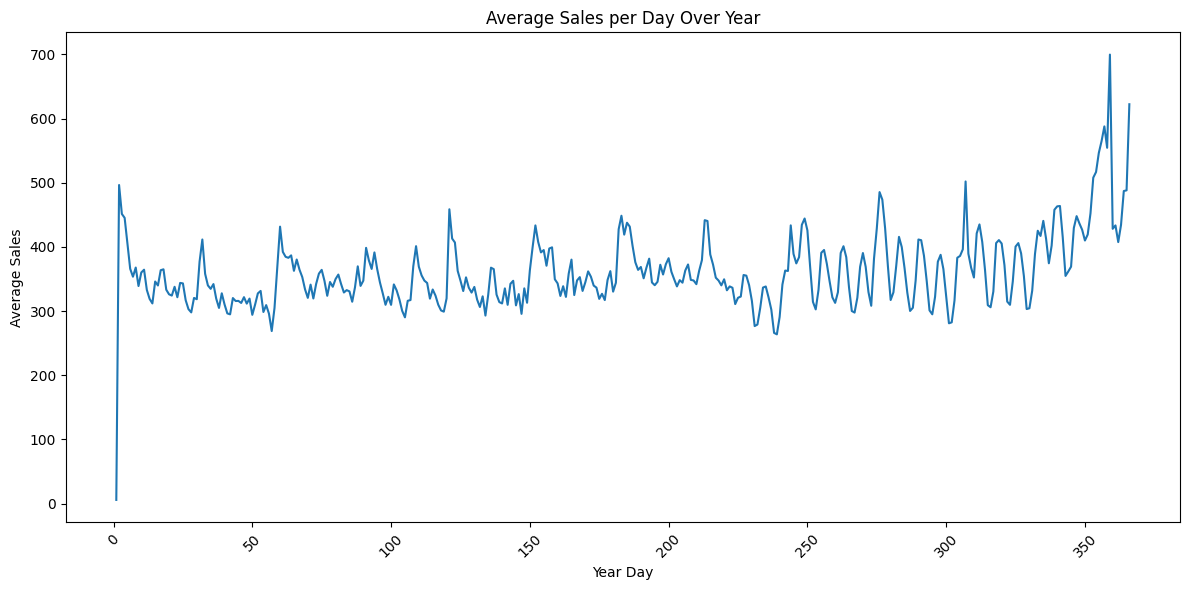

In [ ]:
# Here we observe how sales vary on average per day throughout the year
yearday_sales_avg = daily_sales_avg.groupby(['year_day'])['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data = yearday_sales_avg, x='year_day', y='sales')
plt.xticks(rotation=45)
plt.xlabel('Year Day')
plt.ylabel('Average Sales')
plt.title('Average Sales per Day Over Year')
plt.tight_layout()

plt.show()

# We could observe a very weird drop in the beginning of the year, it might be related to New Year Holiday.
# Sales were better at the end of the year.

###Montly Sales

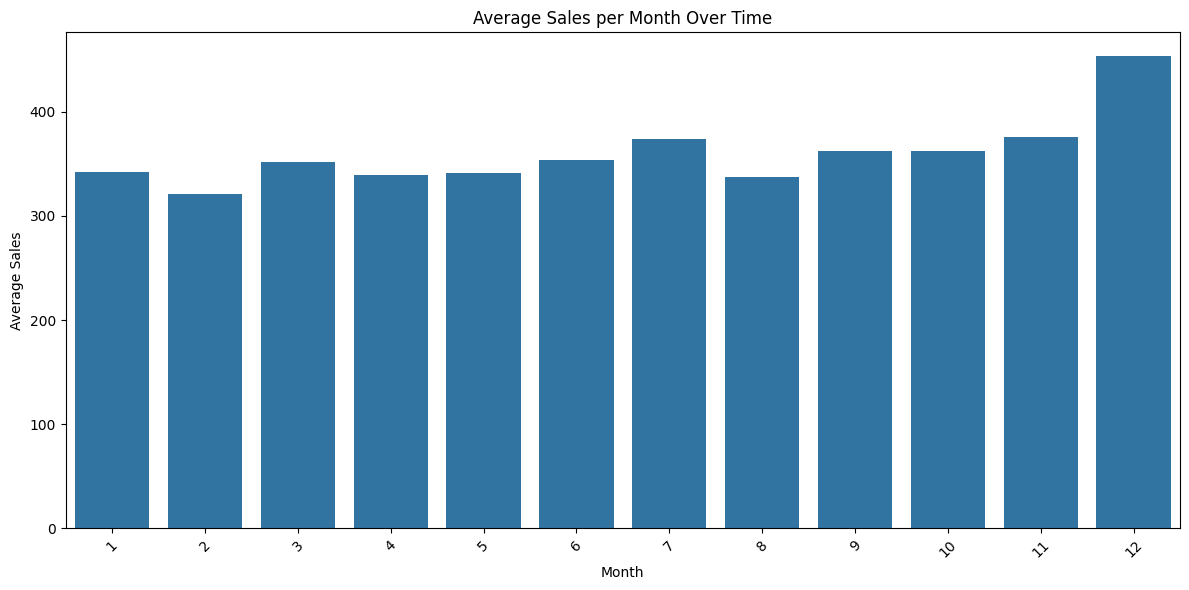

In [ ]:
# Here I was interested in which month had the highest sales
monthly_sales_avg = daily_sales_avg.groupby(['month'])['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data = monthly_sales_avg, x='month', y='sales')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales per Month Over Time')
plt.tight_layout()

plt.show()

# We could observe that December had the highest sales.

###Month Day

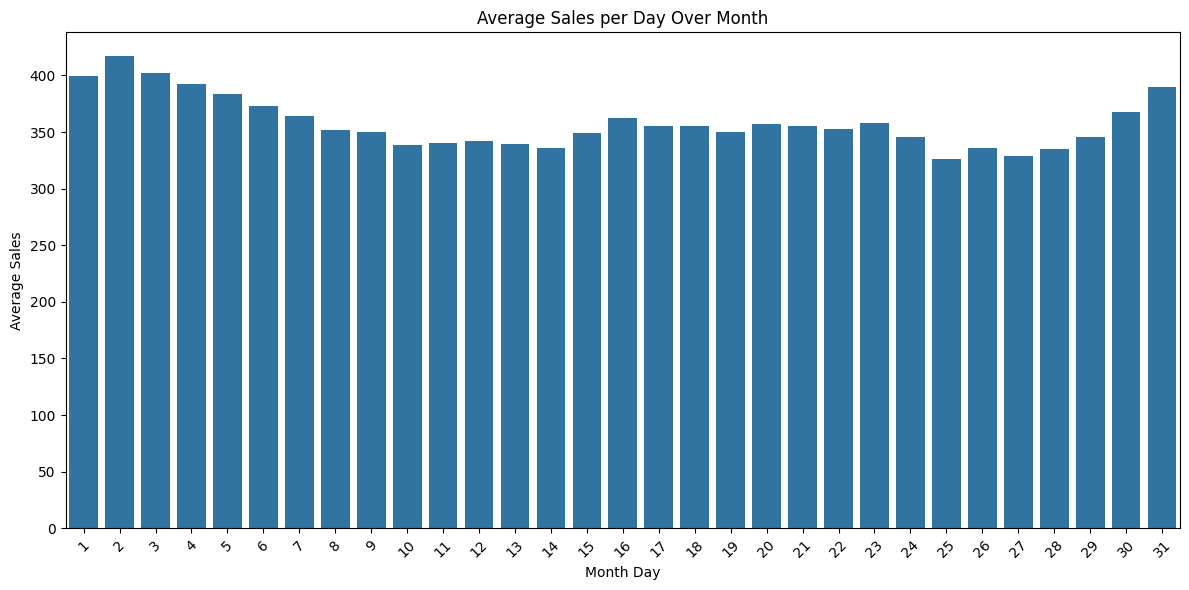

In [ ]:
# Here I wanted to find out the sales pattern within a month
monthday_sales_avg = daily_sales_avg.groupby(['month_day'])['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data = monthday_sales_avg, x='month_day', y='sales')
plt.xticks(rotation=45)
plt.xlabel('Month Day')
plt.ylabel('Average Sales')
plt.title('Average Sales per Day Over Month')
plt.tight_layout()

plt.show()

###Weekly sales

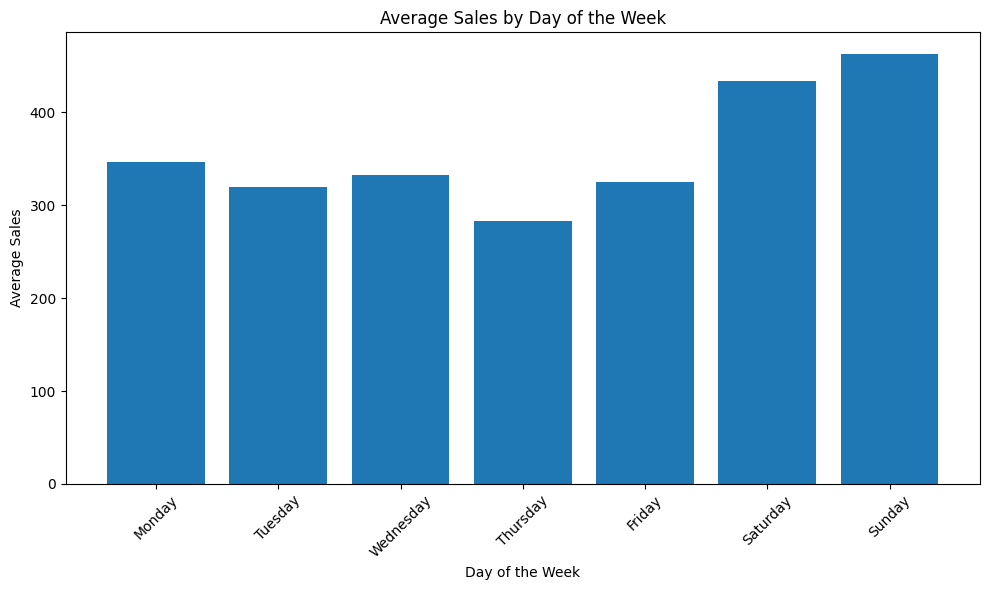

In [ ]:
# Here I wanted to find out how sales changed in different weekdays
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
           4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

daily_sales_avg['weekday'] = daily_sales_avg['weekday'].map(day_map)


average_sales_by_weekday = daily_sales_avg.groupby('weekday')['sales'].mean().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_sales_by_weekday['weekday'] = pd.Categorical(average_sales_by_weekday['weekday'], categories=day_order, ordered=True)
average_sales_by_weekday = average_sales_by_weekday.sort_values('weekday')

plt.figure(figsize=(10, 6))
plt.bar(average_sales_by_weekday['weekday'], average_sales_by_weekday['sales'])
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# The chart again indicated a strong weekly seasonality, it also told us that there are higher sales on weekends on average.

#**3.1 Preprocessing for Original Dataset**

In [ ]:
df3 = df2.copy()

##Grouping Product family & Clustering stores

In [ ]:
# Since we found out that the top 5 product families already account for 80% of total sales,
# I decided to group the remaining families into a family called "other".

# List the top 5 families
top5 = ['GROCERY I','BEVERAGES','PRODUCE','CLEANING','DAIRY']

# Remove the top 5 families to get the remaining families
others = total_sales_by_family[~total_sales_by_family['family'].isin(top5)]
others['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BOOKS', 'BREAD/BAKERY',
       'CELEBRATION', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY II',
       'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
       'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN',
       'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS',
       'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS',
       'POULTRY', 'PREPARED FOODS', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
# replace these remaining families with "OTHERS"
df3['family'].replace(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BOOKS', 'BREAD/BAKERY',
       'CELEBRATION', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY II',
       'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
       'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN',
       'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS',
       'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS',
       'POULTRY', 'PREPARED FOODS', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], "OTHERS", inplace = True)

# check the unique values in product family
df3['family'].unique()

array(['OTHERS', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY', 'GROCERY I'],
      dtype=object)

In [ ]:
df3 = df3.groupby(['date', 'family', 'cluster']).agg({'sales': 'sum', 'onpromotion': 'sum', 'dcoilwtico': 'mean', 'locale': 'first'}).reset_index()
df3

# We greatly reduced the number of records in our dataset, which will reduce the processing time of later modelling tasks.

,date,family,cluster,sales,onpromotion,dcoilwtico,locale
0,2013-01-01,BEVERAGES,1,810.000,0,93.14,National
1,2013-01-01,BEVERAGES,2,0.000,0,93.14,National
2,2013-01-01,BEVERAGES,3,0.000,0,93.14,National
3,2013-01-01,BEVERAGES,4,0.000,0,93.14,National
4,2013-01-01,BEVERAGES,5,0.000,0,93.14,National
...,...,...,...,...,...,...,...
171763,2017-08-15,PRODUCE,13,7753.229,23,47.57,Local
171764,2017-08-15,PRODUCE,14,10768.097,37,47.57,Local
171765,2017-08-15,PRODUCE,15,2555.469,372,47.57,Local
171766,2017-08-15,PRODUCE,16,3164.252,155,47.57,Local


##Creating Time Features

In [ ]:
df3.set_index('date', inplace=True)

# Extract the day of week, month and year from the 'date' column
df3['year'] = df3.index.year
df3['year_day'] = df3.index.day_of_year
df3['month'] = df3.index.month
df3['month_day'] = df3.index.day
df3['weekday'] = df3.index.weekday

##Creating dummy variables for "cluster", "product family" and "locale"

In [ ]:
df4 = df3.copy()

In [ ]:
df4 = pd.get_dummies(df4, columns = ['cluster', 'family', 'locale'])

##Turning data into float

In [ ]:
# We will apply scaler transformation in the later process, so I first transformed values into float here
cols = list(df4)
df4_float = df4[cols].astype(float)

##Spliting Data into Training, Validation, and Testing Dataset

In [ ]:
#Training Data: Starts on 2013-01-01 and ends on 2016-03-26.
#Validation Data: Starts on 2016-03-27 and ends on 2016-12-05.
#Testing Data: Starts on 2016-12-06 and ends on 2017-08-15.

train_end = '2016-03-26'
val_start = '2016-03-27'
val_end = '2016-12-05'
test_start = '2016-12-06'

train_df = df4_float.loc[:train_end]
val_df = df4_float.loc[val_start:val_end]
test_df = df4_float.loc[test_start:]

##Split Data into Features and Label

In [ ]:
X_train = train_df.drop('sales', axis=1)
y_train = train_df['sales']

In [ ]:
X_val = val_df.drop('sales', axis=1)
y_val = val_df['sales']

In [ ]:
X_test = test_df.drop('sales', axis=1)
y_test = test_df['sales']

##Implementing Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# first scale the train dataset
scaler = scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)

In [ ]:
# scale the validation dataset
scaler = scaler.fit(X_val)
X_val_scaler = scaler.transform(X_val)

In [ ]:
# scale the testing dataset
scaler = scaler.fit(X_test)
X_test_scaler = scaler.transform(X_test)

#**3.2 Preprocessing for Aggregated Dataset**

In our original dataset, each date has multiple entries. This makes it difficult for time-series models to detect time steps, since they traditionally expect a single observation per time step. Therefore, here I created aggregated dataset for time-series models, SARIMAX, Neural Prophet, and LSTM.

In [ ]:
df5 = df3.copy()

##Aggregating dataset by "date"

In [ ]:
# Here I aggregated our dataset by 'date', so each date would only had one observation
df5_agg = df5.groupby(['date']).agg({'sales': 'sum','dcoilwtico': 'mean',
                                                 'onpromotion': 'sum',
                                                 'locale': 'first', 'year': 'first', 'year_day': 'first', 'month': 'first', 'month_day': 'first', 'weekday': 'first'})

df5_agg.head()

,sales,dcoilwtico,onpromotion,locale,year,year_day,month,month_day,weekday
date,,,,,,,,,
2013-01-01,2511.618999,93.14,0,National,2013,1,1,1,1
2013-01-02,496092.417944,93.14,0,NaN,2013,2,1,2,2
2013-01-03,361461.231124,92.97,0,NaN,2013,3,1,3,3
2013-01-04,354459.677093,93.12,0,NaN,2013,4,1,4,4
2013-01-05,477350.121229,93.12,0,National,2013,5,1,5,5


##Creating dummy variables for "locale"

In [ ]:
df5_agg = pd.get_dummies(df5_agg, columns = ['locale'])

##Turning data into float

In [ ]:
# I will apply scaler transformation in later process, I transformed our values into float here
cols = list(df5_agg)
df5_agg_float = df5_agg[cols].astype(float)

##Spliting Data into Training, Validation, and Testing Dataset

In [ ]:
#Training Data: Starts on 2013-01-01 and ends on 2016-03-26.
#Validation Data: Starts on 2016-03-27 and ends on 2016-12-05.
#Testing Data: Starts on 2016-12-06 and ends on 2017-08-15.

train_end = '2016-03-26'
val_start = '2016-03-27'
val_end = '2016-12-05'
test_start = '2016-12-06'

train_agg_df = df5_agg_float.loc[:train_end]
val_agg_df = df5_agg_float.loc[val_start:val_end]
test_agg_df = df5_agg_float.loc[test_start:]

##Implementing Scaler

In [ ]:
# first scale the train dataset
scaler = scaler.fit(train_agg_df)
train_agg_scaler = scaler.transform(train_agg_df)

# scale the validation dataset
scaler = scaler.fit(val_agg_df)
val_agg_scaler = scaler.transform(val_agg_df)

# scale the test dataset
scaler = scaler.fit(test_agg_df)
test_agg_scaler = scaler.transform(test_agg_df)

#**4. Modeling on Original Data**

In modeling part, I chose RMSLE as metric for the following reasons.
1. Handling Wide Ranges in Data: Since our data spanned a wide range, RMSLE can be advantageous because it is more concerned with the ratio rather than the difference. This means it penalises relative errors, which is useful when an error of 1,000 is much more significant for a sale of 2,000 compared to a sale of 14,000.

2. Penalising Underestimates More Than Overestimates: RMSLE penalises underestimates more than overestimates. This can be particularly useful in our scenarios where underestimating has a higher cost (e.g., underestimating demand could lead to stockouts,lost sales, and customer dissatisfaction, whereas overestimating might simply mean excess inventory).

Here I forecasted sales based on original datasets for store clusters and product types. These models are not inherently time-aware, like lasso regression, Random Forest, and multilayer perceptron (MLP), but they can still be applied to time-series forecasting by using time-related features we just created.

##4.1 Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha = 0.1)
model.fit(X_train_scaler, y_train)
y_pred = model.predict(X_test_scaler)

y_test_pred_clipped = np.clip(y_pred, 0, None)

squared_log_errors = (np.log1p(y_test_pred_clipped) - np.log1p(y_test)) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e+11, tolerance: 4.517e+08
  model = cd_fast.enet_coordinate_descent(

  model = cd_fast.enet_coordinate_descent(



RMSLE: 2.8845609560398753


Lasso regression is a linear model including L1 regularization to prevent overfitting and perform feature selection. However, its simplicity can be a disadvantage if features and the target variable are complex and non-linear, which is often the case in grocery sales forecasting. We got a high RMSLE of 2.8, which means that Lasso regression was not able to capture the underlying patterns effectively, resulting in underfitting.

##4.2 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)

# training the model
rf_model.fit(X_train_scaler, y_train)

y_pred = rf_model.predict(X_test_scaler)

squared_log_errors = (np.log1p(y_pred) - np.log1p(y_test)) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

RMSLE: 0.854266403065737


I chose Random Forest Regressor as my second model since it is particularly good at handling non-linear data and considering interactions between features. This capability makes it well-suited for our task, where interactions (e.g., holidays and seasonal effects) can be important.
Furthermore, Random Forests are less likely to overfit due to their ensemble nature, which might explain why it got the best RMSLE (around 0.85) among three models I used.

##4.3 Multilayer Perceptron (MLP)

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set random seeds for reproducibility
RAND_SEED = 28
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

In [ ]:
# Build and compile a model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim = X_train_scaler.shape[1]))
# model.add(Dense(units =32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'linear'))

model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse')
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

In [ ]:
history = model.fit(X_train_scaler, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val_scaler, y_val),
                    callbacks = [early_stopping], verbose=1)

Epoch 1/100
3755/3755 [==============================] - 15s 4ms/step - loss: 63951624.0000 - val_loss: 101290680.0000
Epoch 2/100
3755/3755 [==============================] - 23s 6ms/step - loss: 47481488.0000 - val_loss: 73672712.0000
Epoch 3/100
3755/3755 [==============================] - 16s 4ms/step - loss: 28158612.0000 - val_loss: 46649024.0000
Epoch 4/100
3755/3755 [==============================] - 13s 3ms/step - loss: 15892397.0000 - val_loss: 30375048.0000
Epoch 5/100
3755/3755 [==============================] - 13s 3ms/step - loss: 11899306.0000 - val_loss: 25336718.0000
Epoch 6/100
3755/3755 [==============================] - 13s 3ms/step - loss: 11077165.0000 - val_loss: 24365536.0000
Epoch 7/100
3755/3755 [==============================] - 13s 3ms/step - loss: 10771615.0000 - val_loss: 24024954.0000
Epoch 8/100
3755/3755 [==============================] - 13s 3ms/step - loss: 10569659.0000 - val_loss: 23877518.0000
Epoch 9/100
3755/3755 [==============================] 

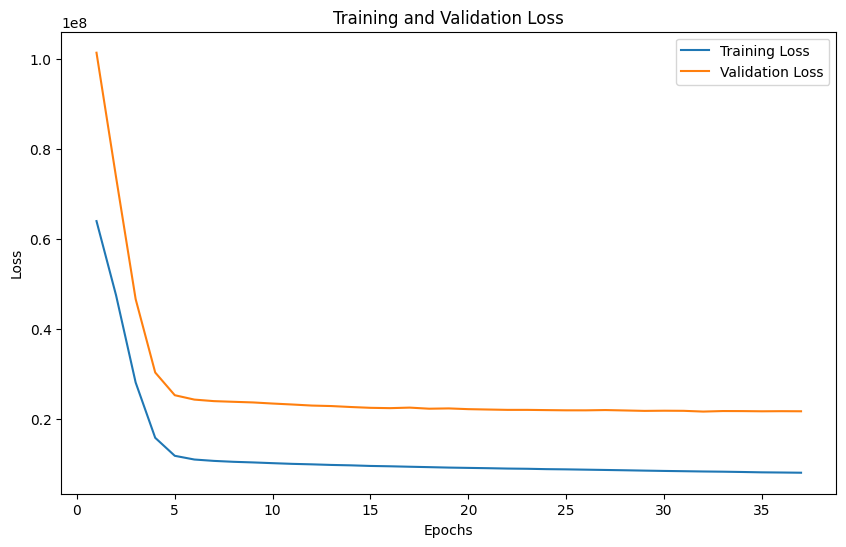

In [ ]:
# Observe the loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test_scaler)

804/804 [==============================] - 2s 2ms/step


In [ ]:
y_pred_clipped = np.clip(y_pred, a_min=0, a_max=None)
y_test_clipped = np.clip(y_test, a_min=0, a_max=None)

y_pred_clipped = np.squeeze(y_pred_clipped)

# Calculate squared log errors using the clipped values
squared_log_errors = (np.log1p(y_pred_clipped) - np.log1p(y_test_clipped)) ** 2

# Calculate mean squared log error
mean_squared_log_error = np.mean(squared_log_errors)

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

RMSLE: 1.315635307056467


MLPs are capable of handling non-linear relationships through multiple layers and non-linear activation functions. However, MLP did not perform the best in my case, because MLPs require careful tuning of parameters such as the number of layers, number of neurons, activation functions, optimisation algorithms, and epochs. Without Hyperparameter tuning, MLP got a RMSLE of around 1.3, which was lower than the Lasso Regression but higher than the Random Forest Regressor.

#**5. Modeling on Aggregated Data (time-series models)**

Time-series models such as SARIMAX, Neural Prophet, and LSTM are often more suitable for sales forecasting compared to more general machine learning models like Random Forest and MLPs. Time-series models account for the order of our data points. They can capture temporal dynamics and seasonality, which are crucial in understanding how grocery sales fluctuate over time due to factors like seasons, and holidays.

Time-series models require each time step only has one observation, so I use the aggregated dataset we created before to run SARIMAX, Neural Prophet and LSTM.

##5.1 SARIMAX with exogenous variables

I chose the Seasonal AutoRegressive Integrated Moving Average with eXogenous variables (SARIMAX) model as the baseline model. This decision was informed by several observations and considerations derived from our initial EDA and SARIMAX's capability. These include observation of Seasonality and Trends in our dataset as well as SARIMAX's ability to include Exogenous Variables.


In [ ]:
# I used Augumented Dickey Fuller (ADF) test to check if the sales is stationary
# Null hypothesis: time series is non-stationary
# Alternative hypothesis: time series is stationary
# So if p-value > 0.05, we cannot reject Null hypothesis, we would need to find the order of differencing

from statsmodels.tsa.stattools import adfuller

result = adfuller(train_agg_df['sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-vaue: {result[1]}")

ADF Statistic: -2.540807954621763
p-vaue: 0.10585831628742626


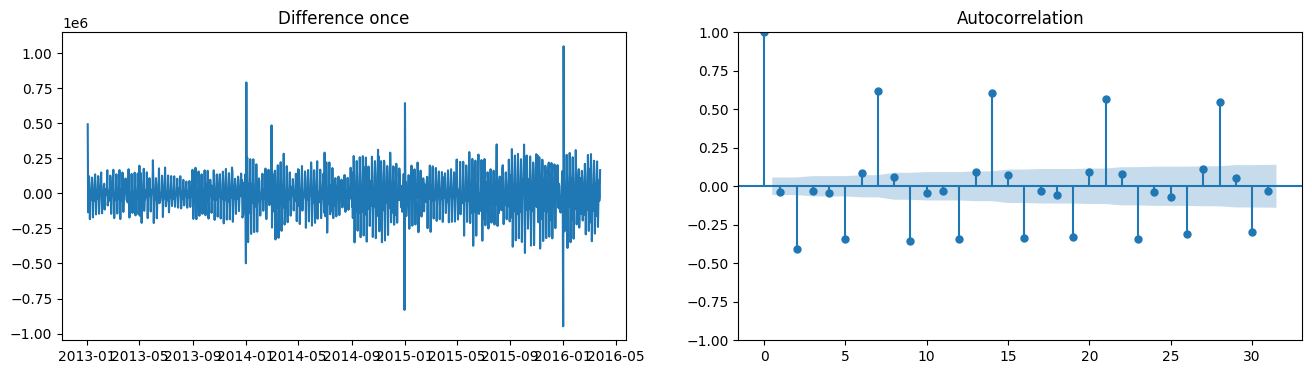

In [ ]:
# Autocorrelation Function (ACF)
# Differencing once
diff = train_agg_df['sales'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax = ax2);

In [ ]:
#here we were not using validation, so I combined train and validaiton dataset
train_agg_sarimax = pd.concat([train_agg_df, val_agg_df], axis=0)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 0, 1)
seasonal_order = (0, 1, 1, 12)

model = SARIMAX(train_agg_sarimax['sales'], exog = train_agg_sarimax[['dcoilwtico', 'onpromotion', 'year', 'year_day',
                                                            'month', 'month_day',	'weekday',	'locale_National',
                                                            'locale_Local',	'locale_Regional']],
                                                            order = order, seasonal_order = seasonal_order)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

  self._init_dates(dates, freq)



In [ ]:
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                 1432
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood              -19134.280
Date:                            Sun, 21 Apr 2024   AIC                          38296.561
Time:                                    14:43:12   BIC                          38370.178
Sample:                                         0   HQIC                         38324.061
                                           - 1432                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
dcoilwtico      -2077.6162    960.472     -2.163      0.031   -3960.106    -195.126
onpromotion       -1

In [ ]:
future_exog = exog = test_agg_df[['dcoilwtico', 'onpromotion', 'year', 'year_day',
                                                            'month', 'month_day',	'weekday',	'locale_National',
                                                            'locale_Local',	'locale_Regional']]

forecast = model_fit.get_forecast(steps= len(test_agg_df), exog = future_exog)
predictions = forecast.predicted_mean
predictions.index = test_agg_df.index

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

  return get_prediction_index(

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(

  return get_prediction_index(



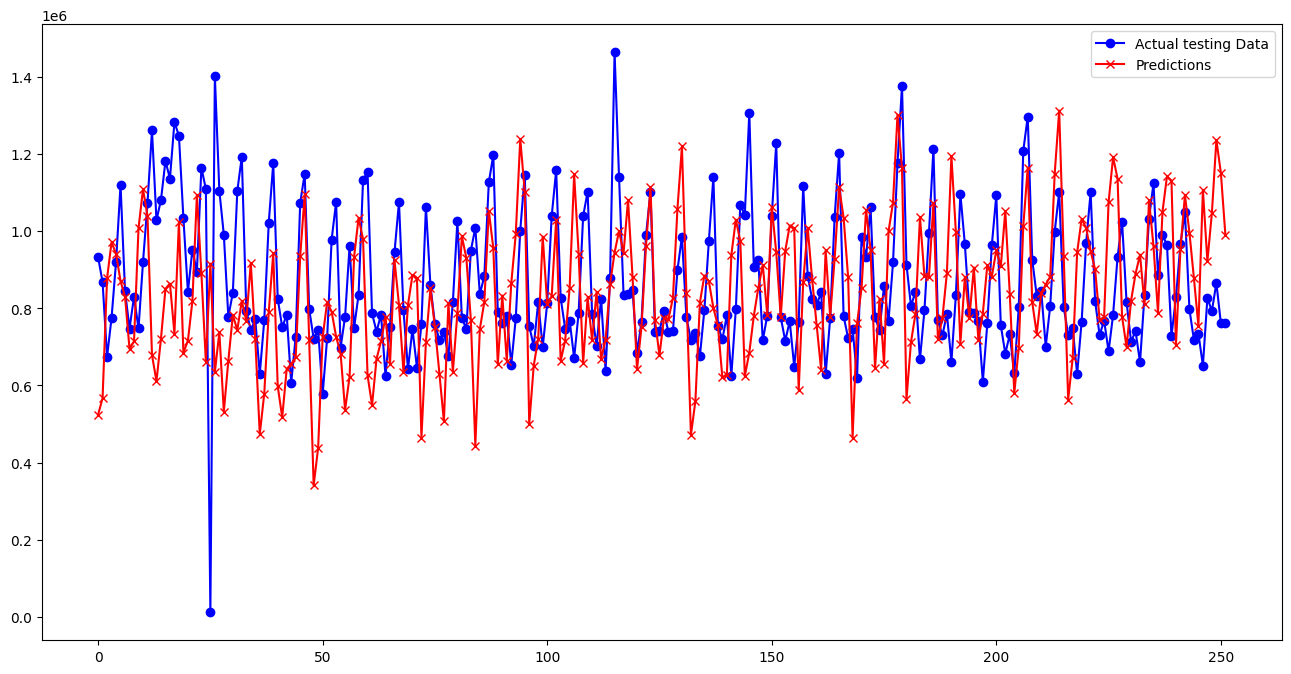

In [ ]:
test_dates_str = test_agg_df.index.astype(str)
pred_dates_str = predictions.index.astype(str)

plt.figure(figsize=(16, 8))

# Plot using position based on length of the series
plt.plot(np.arange(len(test_agg_df)), test_agg_df['sales'], label='Actual testing Data', color='blue', marker='o')
plt.plot(np.arange(len(predictions)), predictions.values, label='Predictions', color='red', marker='x')


plt.legend()
plt.show()

In [ ]:
squared_log_errors = (np.log1p(predictions.values) - np.log1p(test_agg_df['sales'])) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

RMSLE: 0.3804936658377419


Based on the plot, while the model seems to understand the basic ups and downs in sales, it systematically predicted lower values than those actual sales. The model's inclination to predict sales on the lower end suggests a pessimistic forecast, which could lead to stockouts,sales lost, and customer dissatisfaction if applied in real world. The RMSLE is around 0.38, I will compare this to other models in the later process.

##5.2 Neural Prophet

Neural Prophet is a forecasting tool that builds on the traditional Prophet model, introduced by Facebook in 2017. I chose the Neural Prophet model for forecasting sales primarily due to its advanced neural network architecture that builds on the strengths of the traditional Prophet model. This choice was further reinforced by specific characteristics of the sales data and the capabilities of Neural Prophet. First, it can incorporate external variables, like promotions, oil prices, and holidays information, allowing for more nuanced and accurate forecasts that take these important factors into account. Secondly, Neural Prophet is capable of modeling complex non-linear patterns that traditional time series models might struggle with. Given the sales data likely contains such complex patterns, Neural Prophet's neural network architecture can capture these nuances. Last, Neural Prophet can decompose a time series into trend, seasonality, and holiday effects. This is especially useful in our case, where seasonal effects and holidays can have a pronounced impact.





In [ ]:
!pip install neuralprophet

In [ ]:
from neuralprophet import NeuralProphet

#Preparing multivaraite dataframes for Neural Prophet
train_agg_np = train_agg_df.reset_index()
train_agg_np = train_agg_np.rename(columns = {'date': 'ds', 'sales': 'y'})

val_agg_np = val_agg_df.reset_index()
val_agg_np = val_agg_np.rename(columns = {'date': 'ds', 'sales': 'y'})

#here we were not using validation, so I combined train and validaiton dataset
train_agg_np = pd.concat([train_agg_np, val_agg_np], axis=0)

test_agg_np = test_agg_df.reset_index()
test_agg_np = test_agg_np.rename(columns = {'date': 'ds', 'sales': 'y'})

In [ ]:
train_agg_np = train_agg_np.reset_index()
train_agg_np = train_agg_np.drop(columns=['index'])

In [ ]:
train_agg_np

,ds,y,dcoilwtico,onpromotion,year,year_day,month,month_day,weekday,locale_National,locale_Local,locale_Regional
0,2013-01-01,2.511619e+03,93.14,0.0,2013.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,2013-01-02,4.960924e+05,93.14,0.0,2013.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0
2,2013-01-03,3.614612e+05,92.97,0.0,2013.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0
3,2013-01-04,3.544597e+05,93.12,0.0,2013.0,4.0,1.0,4.0,4.0,0.0,0.0,0.0
4,2013-01-05,4.773501e+05,93.12,0.0,2013.0,5.0,1.0,5.0,5.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1427,2016-12-01,8.436033e+05,51.08,12985.0,2016.0,336.0,12.0,1.0,3.0,0.0,0.0,0.0
1428,2016-12-02,8.534549e+05,51.70,18819.0,2016.0,337.0,12.0,2.0,4.0,0.0,0.0,0.0
1429,2016-12-03,1.113441e+06,51.70,14279.0,2016.0,338.0,12.0,3.0,5.0,0.0,0.0,0.0
1430,2016-12-04,1.276195e+06,51.70,15186.0,2016.0,339.0,12.0,4.0,6.0,0.0,0.0,0.0


In [ ]:
# Set the seed to make sure reproducibility
import torch
import random

seed_value = 28

torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [ ]:
# Initiate Neural Prophet
m = NeuralProphet()

# add additional regressors
m.add_future_regressor(name='dcoilwtico')
m.add_future_regressor(name='onpromotion')
m.add_future_regressor(name='year')
m.add_future_regressor(name='year_day')
m.add_future_regressor(name='month')
m.add_future_regressor(name='month_day')
m.add_future_regressor(name='weekday')
m.add_future_regressor(name='locale_National')
m.add_future_regressor(name='locale_Local')
m.add_future_regressor(name='locale_Regional')

# train Neural Prophet
m.fit(train_agg_np, freq = "D", epochs = 100)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.721% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.721% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 

Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,950675.750000,1.154563e+06,0.603398,0.0,0
1,620518.875000,7.933114e+05,0.359602,0.0,1
2,335668.875000,4.599738e+05,0.166406,0.0,2
3,149984.046875,1.972545e+05,0.047333,0.0,3
4,88549.679688,1.153370e+05,0.016655,0.0,4
...,...,...,...,...,...
95,63372.101562,8.715161e+04,0.009667,0.0,95
96,63936.054688,8.638013e+04,0.009644,0.0,96
97,63774.277344,8.767403e+04,0.009831,0.0,97
98,63558.714844,8.731273e+04,0.009714,0.0,98


In [ ]:
forecast = m.predict(test_agg_np)
forecast.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.206% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 45it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly,future_regressors_additive,future_regressor_dcoilwtico,future_regressor_locale_Local,future_regressor_locale_National,future_regressor_locale_Regional,future_regressor_month,future_regressor_month_day,future_regressor_onpromotion,future_regressor_weekday,future_regressor_year,future_regressor_year_day
247,2017-08-11,826373.722022,688812.3750,-59043.210938,-93350.523438,-162216.921875,1.003423e+06,19018.054688,0.000000,49704.128906,0.0,189955.453125,-28198.708984,102430.046875,342371.187500,320115.25,8027.616211
248,2017-08-12,792630.535079,807397.9375,-59391.878906,-93986.375000,-33368.300781,9.941445e+05,19018.054688,0.000000,0.000000,0.0,189955.453125,-31018.578125,60046.441406,427964.000000,320115.25,8063.777832
249,2017-08-13,865639.677471,876717.0000,-59740.605469,-94421.679688,-53088.765625,1.083968e+06,19018.054688,0.000000,0.000000,0.0,189955.453125,-33838.453125,67061.007812,513556.812500,320115.25,8099.938477
250,2017-08-14,760922.406081,646904.2500,-60089.273438,-94658.492188,244008.031250,5.576439e+05,17992.322266,0.000000,0.000000,0.0,189955.453125,-36658.316406,58103.171875,0.000000,320115.25,8136.098633
251,2017-08-15,762661.935939,595044.2500,-60437.937500,-94696.765625,105543.632812,6.446352e+05,17975.507812,-14308.989258,0.000000,0.0,189955.453125,-39478.191406,76611.226562,85592.796875,320115.25,8172.258301


In [ ]:
squared_log_errors = (np.log1p(forecast['yhat1']) - np.log1p(forecast['y'])) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

RMSLE: 0.3198400413511617


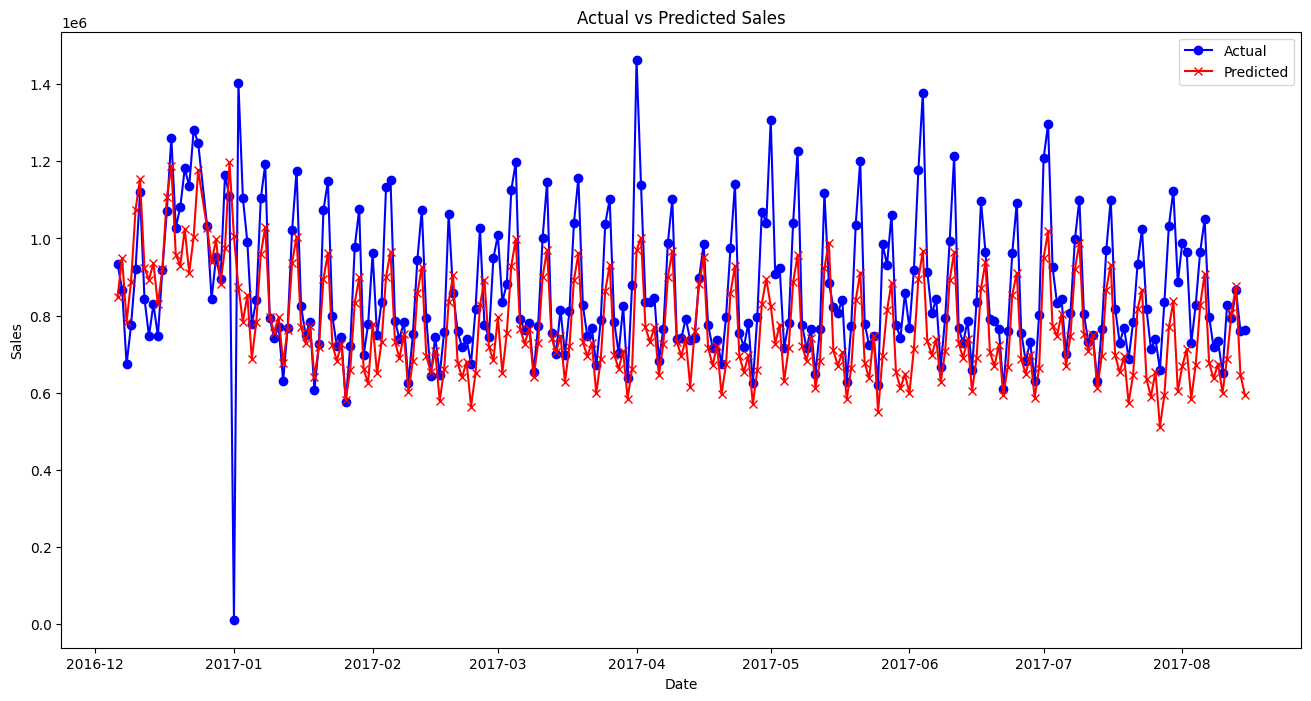

In [ ]:
plt.figure(figsize=(16, 8))

# Plot actual values with circle markers
plt.plot(forecast['ds'], forecast['y'], label='Actual', color='blue', marker='o')

# Plot predicted values with 'x' markers
plt.plot(forecast['ds'], forecast['yhat1'], label='Predicted', color='red', marker='x')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()

plt.show()

From the above chart, the Neural Prophet model appears to capture the overall trend and fluctuations in sales pretty well. It reflects the cyclical nature of the data, mirroring rises and drops in actual sales, though it doesn't always match the peaks and troughs perfectly. The predicted sales are still systemically underestimated compared to the actual sales, the model cannot capture the nuances when the sales are on the higher end. Underestimation can occur because the model may not have enough capacity (e.g., number of layers or neurons) to capture the complexity of the data. However, the RMSLE is around 0.31, which is significantly better than the SARIMAX model. Neural Prophet leverages neural network architectures that can capture complex, non-linear relationships in the data more effectively than traditional time series models like SARIMAX, which are more linear in nature.

##5.3 Long short-term memory (LSTM) network

Long Short-Term Memory networks(LSTM) are a kind of Recurrent Neural Network (RNN), capable of learning long-term dependencies in sequential data. First, the choice of LSTM is due to its capability to learn and remember important information across long sequences when forecasting sales. Secondly, LSTM can handle length variations naturally without the need for fixed-length windowing, which is important for capturing seasonal patterns and trends. Last, LSTM was designed to overcome the limitations of traditional RNNs, especially the vanishing gradient issue, which made it difficult for the network to retain information over long sequences. LSTM mitigates this problem with the gating mechanisms, ensuring that relevant information is retained over time.

In [ ]:
#Preparing input shape for LSTM
def create_sequences(data, window_size, future_step):
    X = []
    y = []
    for i in range(len(data) - window_size - future_step + 1):
        # Create sequences of `window_size` length
        X.append(data[i:(i + window_size), :])
        # Append the target value `future_step` ahead
        y.append(data[i + window_size + future_step - 1, 0])
    return np.array(X), np.array(y)

In [ ]:
window_size = 28
future_step = 1

X_train_lstm, y_train_lstm = create_sequences(train_agg_scaler, window_size, future_step)
X_val_lstm, y_val_lstm = create_sequences(val_agg_scaler, window_size, future_step)
X_test_lstm, y_test_lstm = create_sequences(test_agg_scaler, window_size, future_step)

In [ ]:
print(X_train_lstm.shape, y_train_lstm.shape)

(1150, 28, 11) (1150,)


In [ ]:
# Set random seeds for reproducibility
RAND_SEED = 28
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_data=(X_val_lstm, y_val_lstm), callbacks=[early_stopping], verbose=1)

Epoch 1/100
36/36 [==============================] - 6s 84ms/step - loss: 0.5471 - val_loss: 0.9010
Epoch 2/100
36/36 [==============================] - 3s 73ms/step - loss: 0.4298 - val_loss: 0.9187
Epoch 3/100
36/36 [==============================] - 4s 100ms/step - loss: 0.4223 - val_loss: 0.8405
Epoch 4/100
36/36 [==============================] - 3s 93ms/step - loss: 0.4200 - val_loss: 0.8215
Epoch 5/100
36/36 [==============================] - 3s 75ms/step - loss: 0.3960 - val_loss: 0.8184
Epoch 6/100
36/36 [==============================] - 3s 74ms/step - loss: 0.3958 - val_loss: 0.8419
Epoch 7/100
36/36 [==============================] - 3s 75ms/step - loss: 0.3726 - val_loss: 0.7824
Epoch 8/100
36/36 [==============================] - 5s 151ms/step - loss: 0.3591 - val_loss: 0.8049
Epoch 9/100
36/36 [==============================] - 3s 93ms/step - loss: 0.3497 - val_loss: 0.8315
Epoch 10/100
36/36 [==============================] - 3s 75ms/step - loss: 0.3168 - val_loss: 0.66

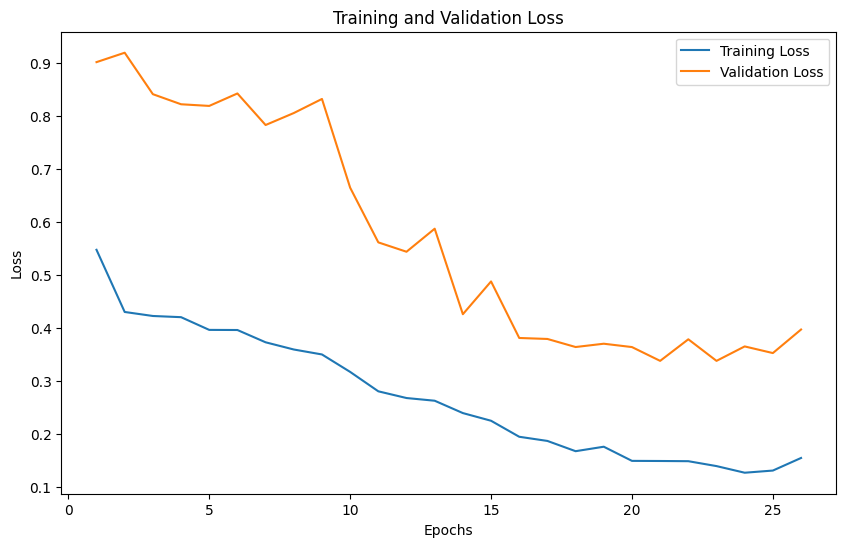

In [ ]:
# Observe the loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_lstm = model.predict(X_test_lstm)
test_loss = model.evaluate(X_test_lstm, y_test_lstm)
print(f'Test Loss: {test_loss}')

7/7 [==============================] - 0s 12ms/step - loss: 0.3222
Test Loss: 0.32215481996536255


In [ ]:
y_pred_copy = np.repeat(y_pred_lstm, 11, axis = -1)
original_scale_y_pred = scaler.inverse_transform(y_pred_copy)[: ,0]

In [ ]:
aligned_actual_sales = test_agg_df['sales'][-len(original_scale_y_pred):]

squared_log_errors = (np.log1p(original_scale_y_pred) - np.log1p(aligned_actual_sales)) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

RMSLE: 0.11650297441743028


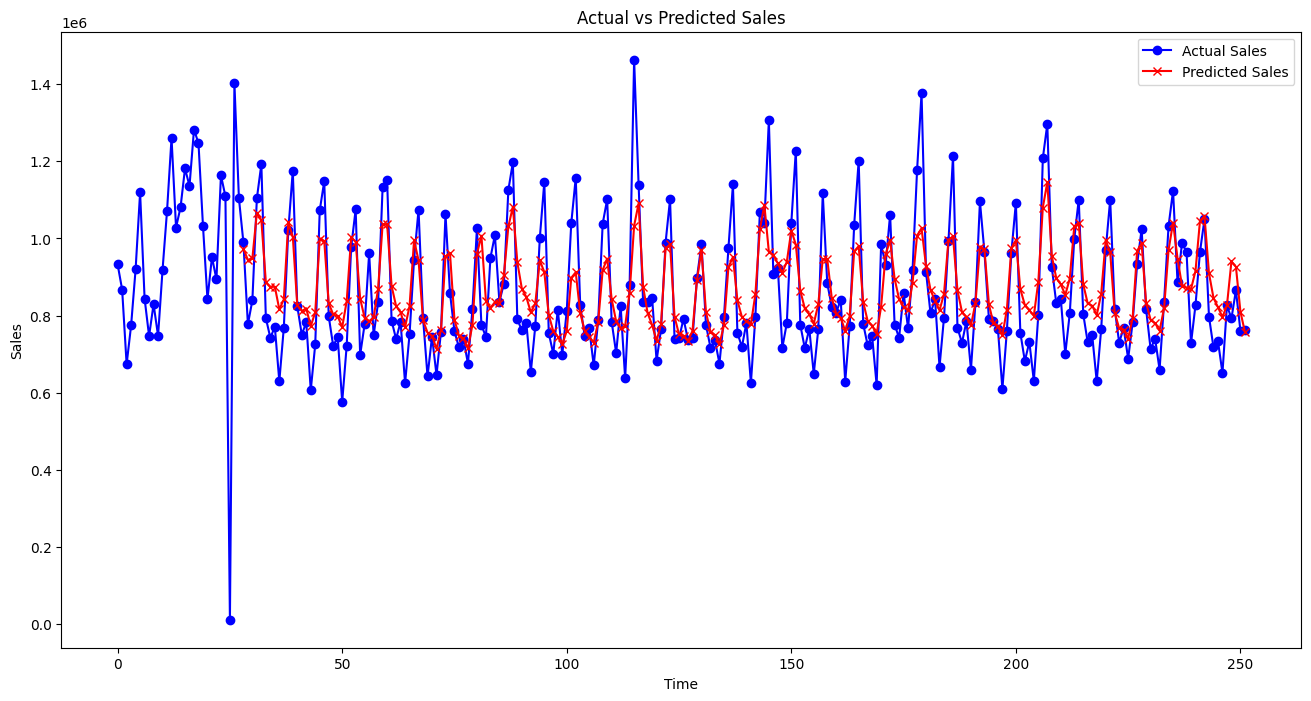

In [ ]:
plt.figure(figsize=(16, 8))

offset = 28
x_values_actual = range(len(test_agg_df['sales']))
x_values_predicted = range(offset, offset + len(original_scale_y_pred))

plt.plot(x_values_actual, test_agg_df['sales'].values, label='Actual Sales', color='blue', marker='o')
plt.plot(x_values_predicted, original_scale_y_pred, label='Predicted Sales', color='red', marker='x')

plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()

plt.show()

According to the above chart, we can see that LSTM performs significantly better than the previous two models(SARIMA and Neural Prophet). Both the actual and predicted sales follow a similar overall trend, indicating that the LSTM model has a good grasp on the general movement of sales over time. The model also captures almost all the peaks and troughs in the sales data, suggesting an understanding of the cyclical nature of the sales patterns. It is interesting to note that there is no consistent bias towards overestimation or underestimation across the entire time series. In some time steps, the predicted values are higher than the actual values, and in others, they are lower. The LSTM model has achieved an RMSLE score of approximately 0.11, marking it as the top performer out of the three models I have created. This is consistent with what the chart illustrates.

However, the predicted sales, while following the trend, smooth out these volatilities to some extent, potentially indicating that our model's capability can be improved to fully capture the rapid changes in sales. I will fine-tune LSTM in the later process to achieve the best result.

#**6. Fine-tuning Models**

Here I chose the algorithms that perform the best on original and aggregated datasets to do hyperparameter tuning. For the original dataset (models that do not consider timestamps), I chose MLP to do fine-tuning. For aggregated datasets (time-series models), I chose LSTM to do fine-tuning. Despite using hyperparameter tuning, the improvement in LSTM performance was marginal, only enhancing from an RMSLE of 0.11 to 0.10.

##Hyperparameter-tuning on LSTM

In [ ]:
pip install keras-tuner

In [ ]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

In [ ]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int(f'units_{i}',
                                        min_value=32,
                                        max_value=256,
                                        step=32),
                           return_sequences=i < (hp.Int('num_layers', 1, 3) - 1),
                           input_shape=self.input_shape))
            model.add(Dropout(rate=hp.Float(f'dropout_{i}',
                                            min_value=0.0,
                                            max_value=0.5,
                                            step=0.1)))
        model.add(Dense(units=1, activation='linear'))

        model.compile(optimizer=Adam(hp.Float('learning_rate',
                                              min_value=1e-4,
                                              max_value=1e-2,
                                              sampling='LOG')),
                      loss='mse')
        return model


input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
hypermodel = LSTMHyperModel(input_shape=input_shape)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_sales_forecast'
)

# Start hyperparameter search
tuner.search(X_train_lstm, y_train_lstm,
             epochs=10,
             validation_data=(X_val_lstm, y_val_lstm),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best found hyperparameters
model = hypermodel.build(best_hps)

Trial 20 Complete [00h 00m 20s]
val_loss: 0.6379994750022888

Best val_loss So Far: 0.28564584255218506
Total elapsed time: 00h 09m 20s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best found hyperparameters
model = hypermodel.build(best_hps)


fixed_epochs = 20
fixed_batch_size = 32

# Train the model using the combined training and validation dataset
best_model = model.fit(X_train_lstm, y_train_lstm,
                       epochs=fixed_epochs,
                       batch_size=fixed_batch_size,
                       validation_data=(X_val_lstm, y_val_lstm),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                       verbose=1)

Epoch 1/20
36/36 [==============================] - 7s 44ms/step - loss: 0.5331 - val_loss: 0.8166
Epoch 2/20
36/36 [==============================] - 0s 11ms/step - loss: 0.4204 - val_loss: 0.7878
Epoch 3/20
36/36 [==============================] - 0s 11ms/step - loss: 0.3186 - val_loss: 0.4854
Epoch 4/20
36/36 [==============================] - 1s 16ms/step - loss: 0.2462 - val_loss: 0.4013
Epoch 5/20
36/36 [==============================] - 1s 17ms/step - loss: 0.1980 - val_loss: 0.3238
Epoch 6/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1749 - val_loss: 0.3557
Epoch 7/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1468 - val_loss: 0.2896
Epoch 8/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1438 - val_loss: 0.2682
Epoch 9/20
36/36 [==============================] - 1s 18ms/step - loss: 0.1320 - val_loss: 0.3081
Epoch 10/20
36/36 [==============================] - 0s 11ms/step - loss: 0.1440 - val_loss: 0.2858
Epoch 11/

In [ ]:
y_pred_lstm = model.predict(X_test_lstm)
test_loss = model.evaluate(X_test_lstm, y_test_lstm)
print(f'Test Loss: {test_loss}')

7/7 [==============================] - 0s 6ms/step - loss: 0.2629
Test Loss: 0.2628585696220398


In [ ]:
y_pred_copy = np.repeat(y_pred_lstm, 11, axis = -1)
original_scale_y_pred = scaler.inverse_transform(y_pred_copy)[: ,0]

In [ ]:
aligned_actual_sales = test_agg_df['sales'][-len(original_scale_y_pred):]

squared_log_errors = (np.log1p(original_scale_y_pred) - np.log1p(aligned_actual_sales)) ** 2
mean_squared_log_error = np.mean(squared_log_errors)
rmsle = np.sqrt(mean_squared_log_error)

print("RMSLE:", rmsle)

RMSLE: 0.10567033360456037


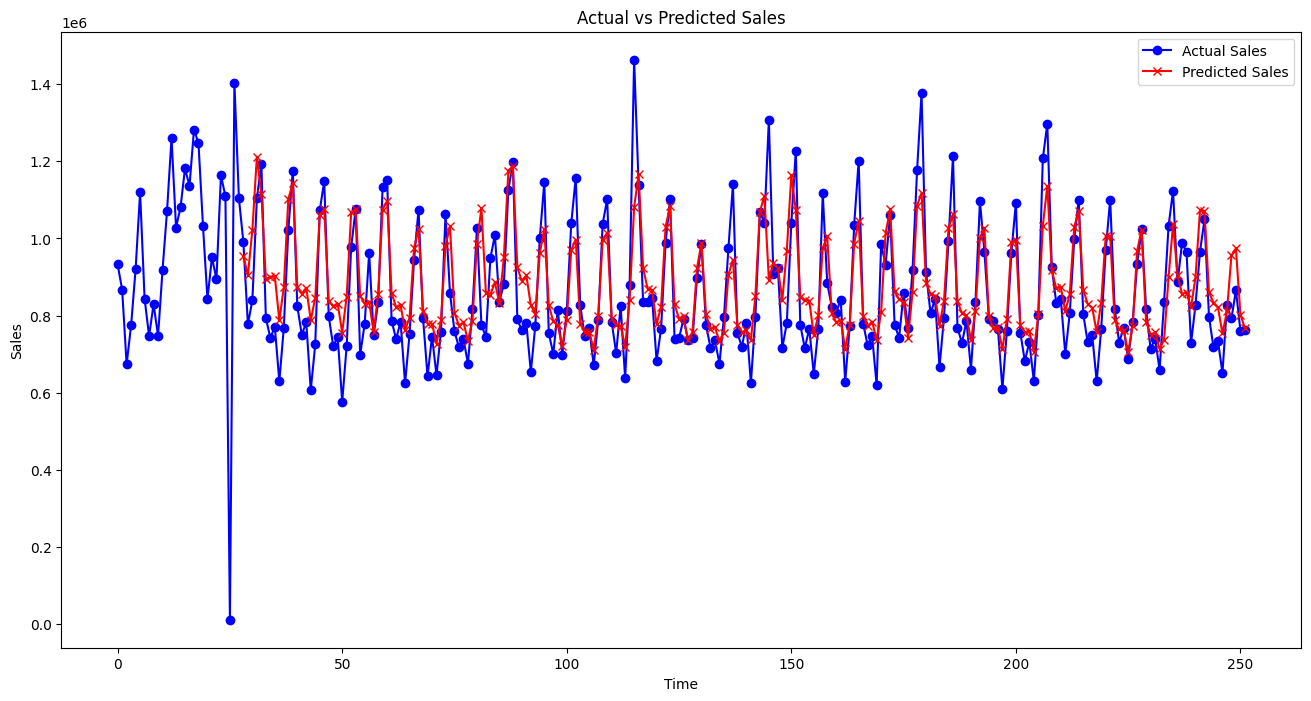

In [ ]:
plt.figure(figsize=(16, 8))

offset = 28
x_values_actual = range(len(test_agg_df['sales']))
x_values_predicted = range(offset, offset + len(original_scale_y_pred))

plt.plot(x_values_actual, test_agg_df['sales'].values, label='Actual Sales', color='blue', marker='o')  # Plot actual sales
plt.plot(x_values_predicted, original_scale_y_pred, label='Predicted Sales', color='red', marker='x')  # Plot predictions

plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()

plt.show()

#**7. Conclusion**

We assessed the performance of various machine learning models, including Lasso Regression, Random Forest Regressor and Multilayer Perceptron (MLP), as well as several time-series models such as SARIMAX, Neural Prophet and LSTM.

Random Forest Regressor performed the best with original datasets, outperforming the MLP. The Random Forest's ability to handle overfitting through ensemble averaging contributed to its high performance. Among the time-series models, LSTM demonstrated the best performance, surpassing SARIMAX and Neural Prophet. The strength of LSTM can be attributed to its capability to capture long-term dependencies and complex patterns in our datasets. SARIMAX and Neural Prophet were good at understanding seasonal trends and the impact of external factors such as holidays and promotions. However, they did not achieve the same performance as LSTM, possibly due to their limitations in understanding more nuanced temporal dependencies that LSTMs can capture.

The findings from this project highlight the importance of choosing the right model based on the data's specific attributes. In this project, it is obvious that time-series models, which account for temporal sequences, consistently outperformed models that do not. This is particularly relevant in grocery sales forecasting, where understanding and leveraging patterns over time is crucial for forecasting. For future work, I would like to create a Hybrid model that combine the strengths of Random Forest Regressor with LSTM, which could leverage both the non-linear feature handling capability of Random Forest and the temporal pattern recognition ability of LSTM.

#**Appendix**

##Bibliography:
“Complete Guide to SARIMAX in Python for Time Series Modeling.” [Online] Available at: https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

“Sales_Forecast-Time_Series/Time_series_LSTM_model.ipynb at Main · Ruparna25/Sales_Forecast-Time_Series.” [Online] Available at:https://github.com/Ruparna25/Sales_Forecast-Time_Series/blob/main/time_series_LSTM_model.ipynb

“NeuralProphet Documentation.” [Online] Available at:https://neuralprophet.com/tutorials/tutorial01.html

“M4-Methods/118 - Slaweks17/ES_RNN_SlawekSmyl.pdf at Slaweks_ES-RNN · Mcompetitions/M4-Methods.” [Online] Available at:https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf

Chowdhury, Kuldeep. “10 Hyperparameters to Keep an Eye on for Your LSTM Model — and Other Tips.” [Online] Available at:https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4
